In [54]:
import pandas as pd
import os 
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

In [55]:
for file in os.listdir():
    print(file)

damir_data.ipynb
Test Survey_Juan.xlsx


### Read all sheets in excel file

In [56]:
xl = pd.ExcelFile('Test Survey_Juan.xlsx')

### Loop through sheets

In [57]:
sheet_dict = {}

for sheet in xl.sheet_names:
    df = xl.parse(sheet)
    sheet_dict[sheet] = df

### Define function

In [58]:
def drilling_function(df_inital_data,bin,metadata):
    df_inital_data['INC Rad'] = df_inital_data['Incl'].apply(lambda x: math.radians(x))
    df_inital_data['AZI Rad'] = df_inital_data['Azm (°)'].apply(lambda x: math.radians(x))
    df_inital_data['DLS Rad'] = df_inital_data['DLS'].apply(lambda x: math.radians(x))
    df_inital_data
    
    filter_df = df_inital_data.loc[df_inital_data['MD (ft)']<bin]
    
    filter_df.loc[:,'Weight of Pipe Above']= ((filter_df['MD (ft)'] - filter_df['MD (ft)'].loc[0])*(metadata.get('Pipe(lb/ft)'))+metadata.get('ESP Weight(lbs)'))
    
    filter_df.loc[:,'K'] = (filter_df['Weight of Pipe Above']/(metadata.get('E(psi)')*metadata.get('MOI (in^4)')))**(1/2)
    
    filter_df.loc[:,'tanh eq'] = np.tanh(filter_df['K']*metadata.get('Half-Length(in)'))/(filter_df['K']*metadata.get('Half-Length(in)'))
    
    filter_df.loc[:,'DLS Side Force (psi)'] = (filter_df['DLS']/(filter_df['tanh eq']))*(np.pi/432000)*metadata.get('E(psi)')*metadata.get('OD(in)')
    filter_df.loc[:,'DLS Side Force (lbf)'] = filter_df.loc[:,'DLS Side Force (psi)']*metadata.get('Area(in^2)')
    
    filter_df['Fnormal (total)'] = (filter_df['MD (ft)'])*metadata.get('Pipe(lb/ft)')*np.sin(filter_df['INC Rad'])
    filter_df['Fnormal (total) shifted']=filter_df['Fnormal (total)'].shift(-1)
        
    filter_df['Fnormal (lbf/joint)'] = filter_df['Fnormal (total) shifted']/(filter_df['MD (ft)']/30)
    filter_df['DLS Side Force (lbf/joint)'] = filter_df['DLS Side Force (lbf)']/(filter_df['MD (ft)'].max()/30)

    filter_df['Total Side Load (lbf/joint)'] = np.abs(filter_df['Fnormal (total)'])
    
    filter_df['Side Load + Inc'] = filter_df['Fnormal (lbf/joint)']+filter_df['DLS Side Force (lbf/joint)']
    
    return filter_df

In [59]:
metadata = {'MOI (in^4)':2.302849714,
'Pipe(lb/ft)' :6.5,
'Area(in^2)':2.857925687,
'OD(in)':	2.875,
'ID(in)': 2.151,
'Half-Length(in)':	180,
'E(psi)':	30000000,
'ESP Weight(lbs)':	5000}

In [60]:
df_inital_data_1 = list(sheet_dict.values())[0]
df_inital_data_1

,Well Name,Survey,KOP,Max Incl,ALType,KOP(MD ft),PKR Depth(MD ft),KOP(TVD ft),PKR Depth(TVD ft),Top Pref,PKR Inc(deg),Max DLS
0,Test,FINAL SURVEY,8198.0,11.36,ESP,8198,7770,7992.24,7564.9,8806,0.28,3.36


In [61]:
df_inital_data = list(sheet_dict.values())[1]
df_inital_data

,MD (ft),Incl,Azm (°),TVD (ft),NS (ft),EW (ft),DLS,PKR,KOP
0,25,0.00,0.00,25.00,0.00,0.00,0.00,NaN,NaN
1,154,0.60,14.00,154.00,0.66,0.16,0.47,NaN,NaN
2,241,0.50,22.10,240.99,1.45,0.42,0.15,NaN,NaN
3,329,0.40,135.70,328.99,1.58,0.78,0.86,NaN,NaN
4,420,1.30,168.20,419.98,0.35,1.21,1.08,NaN,NaN
...,...,...,...,...,...,...,...,...,...
210,18870,90.35,0.72,8447.89,9299.15,-265.39,0.68,NaN,NaN
211,18960,90.71,0.55,8447.06,9389.14,-264.40,0.44,NaN,NaN
212,19050,91.05,0.65,8445.67,9479.12,-263.45,0.39,NaN,NaN
213,19088,91.78,0.80,8444.73,9517.11,-262.97,1.96,NaN,NaN


### Define bin

In [62]:
bin = 550

In [63]:
dataframe_dict = {}

for value in np.arange(bin,df_inital_data_1['KOP'].values[0]+bin,bin):
    
    df_test = drilling_function(df_inital_data,value,metadata)
    dataframe_dict[value] = df_test[['MD (ft)','Side Load + Inc']]
    

C:\Users\jfhur\AppData\Local\Temp\ipykernel_26820\1615437580.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df.loc[:,'Weight of Pipe Above']= ((filter_df['MD (ft)'] - filter_df['MD (ft)'].loc[0])*(metadata.get('Pipe(lb/ft)'))+metadata.get('ESP Weight(lbs)'))
C:\Users\jfhur\AppData\Local\Temp\ipykernel_26820\1615437580.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df.loc[:,'K'] = (filter_df['Weight of Pipe Above']/(metadata.get('E(psi)')*metadata.get('MOI (in^4)')))**(1/2)
C:\Users\

In [66]:
different_depths_calc_df = pd.concat(dataframe_dict,axis=1)
different_depths_calc_df

550.0                   1100.0                  1650.0                  \
   MD (ft) Side Load + Inc MD (ft) Side Load + Inc MD (ft) Side Load + Inc   
0     25.0       12.578707    25.0       12.578707    25.0       12.578707   
1    154.0       90.203719   154.0       44.403200   154.0       30.980143   
2    241.0       30.810132   241.0       15.662862   241.0       11.223553   
3    329.0      177.375774   329.0       87.529174   329.0       61.197246   
4    420.0      232.099042   420.0      115.459832   420.0       81.275618   
..     ...             ...     ...             ...     ...             ...   
88     NaN             NaN     NaN             NaN     NaN             NaN   
89     NaN             NaN     NaN             NaN     NaN             NaN   
90     NaN             NaN     NaN             NaN     NaN             NaN   
91     NaN             NaN     NaN             NaN     NaN             NaN   
92     NaN             NaN     NaN             NaN     NaN             NaN   

    2200.0                  2750.0                  ...  6050.0  \
   MD (ft) Side Load + Inc MD (ft) Side Load + Inc  ... MD (ft)   
0     25.0       12.578707    25.0       12.578707  ...    25.0   
1    154.0       23.601086   154.0       19.390119  ...   154.0   
2    241.0        8.783131   241.0        7.390469  ...   241.0   
3    329.0       46.721793   329.0       38.461167  ...   329.0   
4    420.0       62.483529   420.0       51.759551  ...   420.0   
..     ...             ...     ...             ...  ...     ...   
88     NaN             NaN     NaN             NaN  ...     NaN   
89     NaN             NaN     NaN             NaN  ...     NaN   
90     NaN             NaN     NaN             NaN  ...     NaN   
91     NaN             NaN     NaN             NaN  ...     NaN   
92     NaN             NaN     NaN             NaN  ...     NaN   

                    6600.0                  7150.0                  7700.0  \
   Side Load + Inc MD (ft) Side Load + Inc MD (ft) Side Load + Inc MD (ft)   
0        12.578707    25.0       12.578707    25.0       12.578707    25.0   
1        10.105273   154.0        9.494029   154.0        8.971145   154.0   
2         4.319760   241.0        4.117608   241.0        3.944678   241.0   
3        20.247141   329.0       19.048067   329.0       18.022327   329.0   
4        28.114031   420.0       26.557388   420.0       25.225769   420.0   
..             ...     ...             ...     ...             ...     ...   
88             NaN     NaN             NaN     NaN             NaN     NaN   
89             NaN     NaN             NaN     NaN             NaN     NaN   
90             NaN     NaN             NaN     NaN             NaN     NaN   
91             NaN     NaN             NaN     NaN             NaN     NaN   
92             NaN     NaN             NaN     NaN             NaN     NaN   

                    8250.0                  
   Side Load + Inc MD (ft) Side Load + Inc  
0        12.578707      25       12.578707  
1         8.524144     154        8.151657  
2         3.796845     241        3.673655  
3        17.145449     329       16.414742  
4        24.087402     420       23.138796  
..             ...     ...             ...  
88             NaN    8043       11.826020  
89             NaN    8107       84.141256  
90             NaN    8127      440.229177  
91             NaN    8153      367.286965  
92             NaN    8198             NaN  

[93 rows x 30 columns]

In [98]:
final_value_list = []
index_list = []
for value in np.arange(bin,df_inital_data_1['KOP'].values[0]+bin,bin):
    final_value_list.append(different_depths_calc_df[(value,'Side Load + Inc')])
    if value > df_inital_data_1['KOP'].values[0]:
       index_list.append(different_depths_calc_df[(value,'MD (ft)')].values)

In [100]:
final_df = pd.concat(final_value_list,axis=1)
final_df.index = index_list[0]

In [121]:
final_dict = {}

for idx, row in final_df.iterrows():
    final_dict[np.max(row)] = [idx]

In [128]:
final_plot_df = pd.DataFrame.from_dict(final_dict).T
final_plot_df.columns = ['value']
final_plot_df

,value
12.578707,25
90.203719,154
30.810132,241
177.375774,329
232.099042,420
...,...
11.826020,8043
84.141256,8107
440.229177,8127
367.286965,8153


<Figure size 640x480 with 0 Axes>

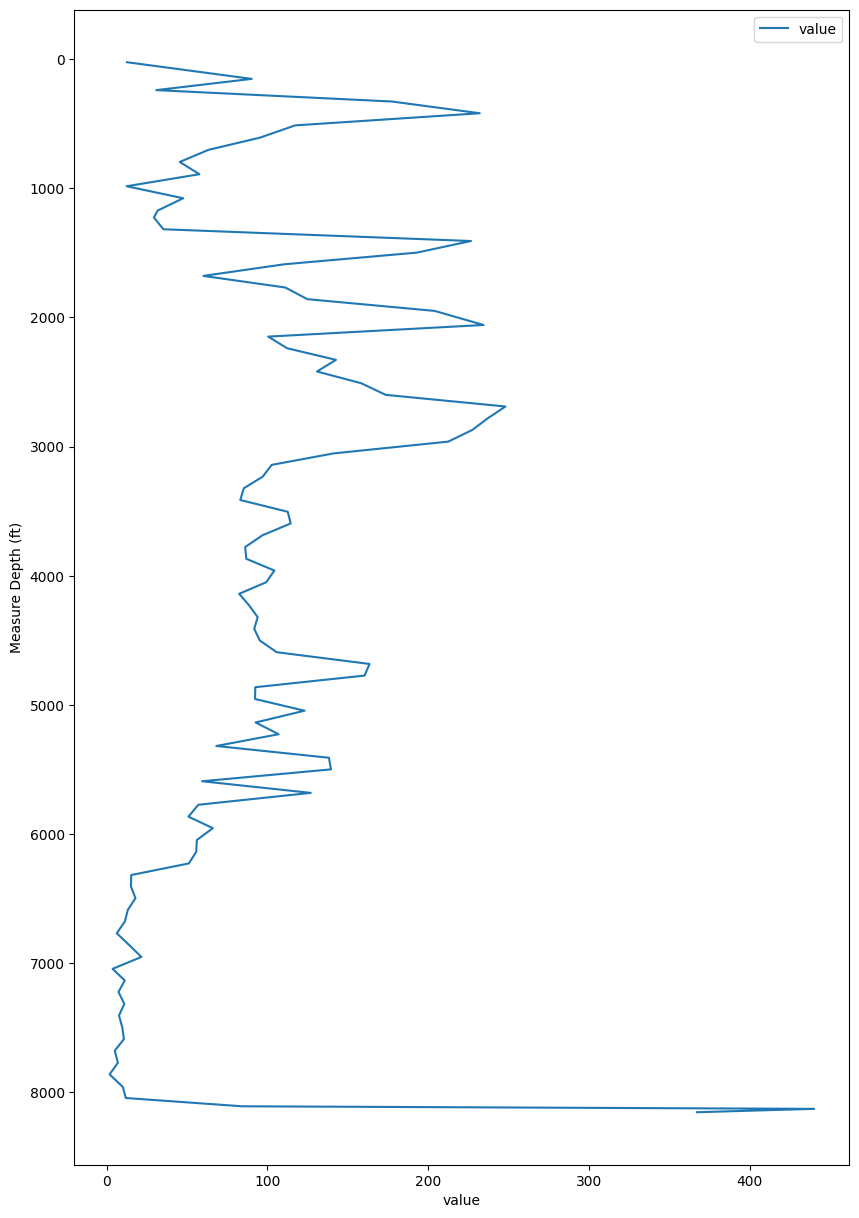

In [131]:
plt.figure()
final_plot_df.plot(kind='line',figsize=(10,15))
plt.ylabel('Measure Depth (ft)')
plt.xlabel('value')
plt.gca().invert_yaxis()